In [10]:
import torch
import torch.nn as nn
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels, 
                      kernel_size=4, 
                      stride=stride,
                      padding=1,
                      bias=True,
),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.conv(x)

class Disc(nn.Module):
    def __init__(self,in_channels):
        super(Disc,self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=64,
                kernel_size=4, 
                stride=2,
                padding=1,
                padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )

        self.process = nn.Sequential(
            conv_block(64, 128, 2),
            conv_block(128, 256, 2),
            conv_block(256, 512, 1),
            nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode='reflect'),
            nn.Sigmoid()
        )

    def forward(self, x):   
        x = self.initial(x)
        x = self.process(x)
        return x
        

In [9]:
x = torch.randn(1,1,256,256)
model = Disc(1)
assert model(x).shape == (1,1,30,30)

In [2]:
class Generator(nn.Module):
    def __init__(self , in_channels , out_channels):
        super(Generator,self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=64,
                kernel_size=7, 
                stride=1,
                padding=3,
                padding_mode="reflect"),
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )

        self.process = nn.Sequential(
            conv_block(64, 128, 2),
            conv_block(128, 256, 2),
            conv_block(256, 512, 2),
            conv_block(512, 1024, 2),
            conv_block(1024, 2048, 2),
            conv_block(2048, 1024, 2),
            conv_block(1024, 512, 2),
            conv_block(512, 256, 2),
            conv_block(256, 128, 2),
            conv_block(128, 64, 2),
        )

        self.final = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=out_channels,
                kernel_size=7,
                stride=1,
                padding=3,
                ),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        #x = self.process(x)
        x = self.final(x)
        return x
    

class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden= 40 ,N_layers = 2):
        super(Net,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

In [29]:
x = torch.randn(1,3,256,256)
model = Generator(3,1)
#assert model(x.view(1,-1)).shape == (1,3*256*256)
print(model(x).shape)
assert model(x).shape == (1,1,256,256)


torch.Size([1, 1, 256, 256])


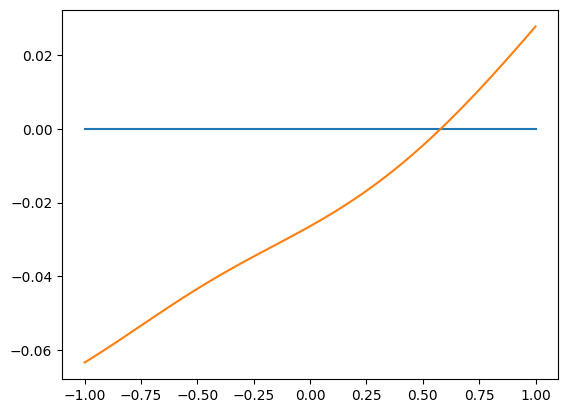

In [42]:
x = torch.linspace(-1,1,100)
initial_condition = torch.exp(-10*(x**2+9))

model = Net(1,1)

plt.plot(x,initial_condition)
plt.plot(x,y.detach().numpy())

In [57]:
"""def poisson(x, y ,pinn):
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = ui(x, y ,pinn)
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]
    return u_xx + u_yy """




generator = Net(2,1)
generator2 = Generator(2,1)
discriminator = Disc(1)
disc_optimize = torch.optim.Adam(Disc(1).parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_optimize = torch.optim.Adam(generator.parameters(), lr=0.01)
epochs = 10
#x = torch.randn(1,1,256)
#y = torch.randn(1,1,256)
x=  torch.linspace(0,1,256)
y=  torch.linspace(0,1,256)
print(x.shape)

x,y = torch.meshgrid(x,y) 
x =x.unsqueeze(0)
y = y.unsqueeze(0)

print(x.shape)
#x = x.reshape(1,1,256,256)
#y = y.reshape(1,1,256,256)


for epoch in range(epochs):



    x.requires_grad_(True)
    y.requires_grad_(True)
    
    X = torch.cat([x, y], dim=0).unsqueeze(0) #dimensin sould be torch.Size([65536, 2]) for Net and torch.Size([1, 2, 256, 256]) for Generator
   
    print(X.shape)
    
    u = generator2(X).view(256,256)
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]
    
    
    fake_equation = u_xx + u_yy 
    exac_equation = torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) +torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
    fake_solution = generator2(X).view(256,256)
    
    initial_condition = torch.exp(-10*(x**2+9))
    boundary_condition = torch.exp(-10*(0**2+y**2))

    initial_points = torch.cat([x,-3*torch.ones_like(x)],dim=0).unsqueeze(0)
    print(initial_points.shape)
    fake_initial = generator2(initial_points)

    initial_loss = torch.mean((fake_initial - initial_condition)**2)

    disc_fake = discriminator(fake_equation.unsqueeze(0))
    disc_real = discriminator(exac_equation.unsqueeze(0))

    disc_loss = (torch.mean((disc_fake - 0)**2) + torch.mean((disc_real - 1)**2))/2
    disc_optimize.zero_grad()
    disc_loss.backward()
    disc_optimize.step()

    

    gen_optimize.zero_grad()
    

    gen_loss = ((torch.mean((fake_equation - exac_equation)**2) + initial_loss ))/2
    gen_loss.backward()
    gen_optimize.step()

      






torch.Size([256])
torch.Size([1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

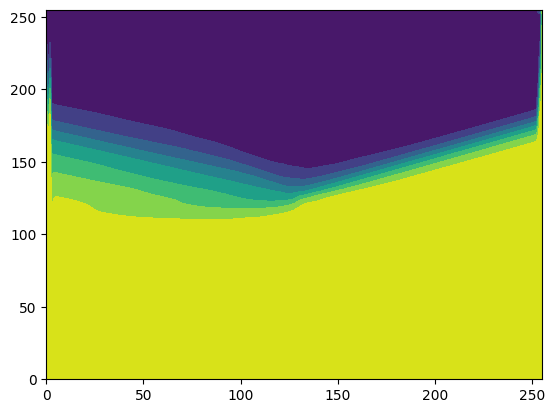

In [56]:
import matplotlib.pyplot as plt
plt.contourf(u.detach().numpy().reshape(256,256))

In [1]:
import jax
import jax.numpy as jnp
#import equinox as eqx
#import optax
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [6]:
import scipy
import os


print(scipy.__version__)
print(os.path.dirname(scipy.__file__))

1.11.3
c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy


In [2]:
path = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Layouni\burgers_data_R10.mat"

data = scipy.io.loadmat(path)


dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])
(2048, 8192) (2048, 8192)


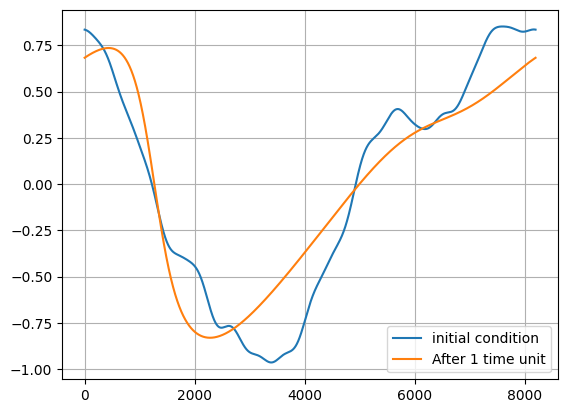

In [3]:
print(data.keys())

a = data['a']
u = data['u']

print(a.shape, u.shape)

plt.plot(a[0], label="initial condition")
plt.plot(u[0], label="After 1 time unit")
plt.legend()
plt.grid()

In [84]:
a = torch.tensor(a).unsqueeze(1)
u = torch.tensor(u).unsqueeze(1)

torch.Size([8192])


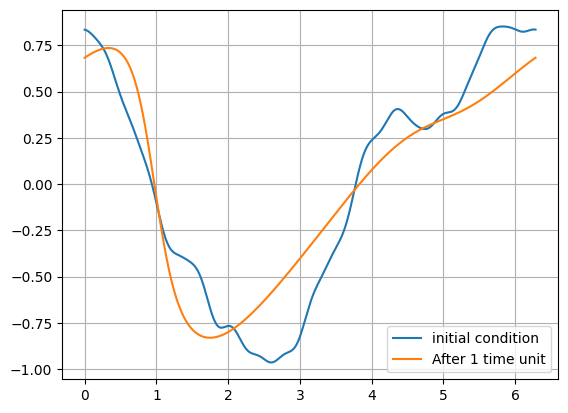

In [85]:

mesh = torch.linspace(0,2*torch.pi , u.shape[-1])
print(a[0, 0].shape)
#mesh = mesh.unsqueeze(0).unsqueeze(0)

plt.plot(mesh, a[0, 0], label="initial condition")
plt.plot(mesh, u[0, 0], label="After 1 time unit")
plt.legend()
plt.grid()

In [93]:

mesh_shape_corrected = mesh.unsqueeze(0).unsqueeze(0).repeat(u.shape[0], 1, 1)
a_with_mesh = torch.cat((a, mesh_shape_corrected), dim=1)

X_train,X_test = a_with_mesh[:1000], a_with_mesh[1000:1200]
y_train,y_test = u[:1000], u[1000:1200]


In [4]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


In [5]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

In [11]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(2, self.width) # input channel_dim is 2: (u0(x), x)
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width*2)  # output channel_dim is 1: u1(x)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)

        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [12]:
modes = 16
width = 64

model = FNO1d(modes, width)

In [13]:
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

x_train = a[:ntrain,:]
y_train = u[:ntrain,:]
x_test = a[-ntest:,:]
y_test = u[-ntest:,:]


x_train = x_train.reshape(ntrain,8192,1)
x_test = x_test.reshape(ntest,8192,1)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(x_train.shape, y_train.shape)

train_data = torch.utils.data.TensorDataset(x_train, y_train)
test_data = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 50
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)



torch.Size([1000, 8192, 1]) torch.Size([1000, 8192])


In [16]:
import numpy as np
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

epochs = 1
for ep in range(epochs):
    model.train()
    
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x, y
        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        
        mse.backward() 

        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x, y

            out = model(x)
            test_l2 += F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    
    print(ep, train_mse, train_l2, test_l2)


0 0.1442600811831653 0.0 tensor(0.0007)


(50, 8192) (50, 8192) (50, 8192, 1)


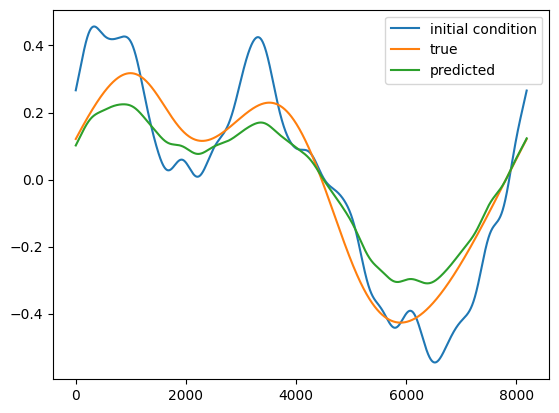

In [25]:
#plotting the results
model.eval()
x, y = next(iter(test_loader))

out = model(x)
out = out.detach().numpy()
x = x.squeeze().detach().numpy()
y = y.detach().numpy()
print(x.shape, y.shape, out.shape)

plt.plot(x[0, :], label='initial condition')
plt.plot( y[0, :], label='true')
plt.plot( out[0, :, 0], label='predicted')
plt.legend()
plt.show()

In [101]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


def data_loader(key , x, y, batch_size):
    n_samples = x.shape[0]

    n_batches = int(torch.ceil(torch.tensor(n_samples / batch_size)))


    permutation = torch.randperm(n_samples)
    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield x[batch_indices], y[batch_indices]

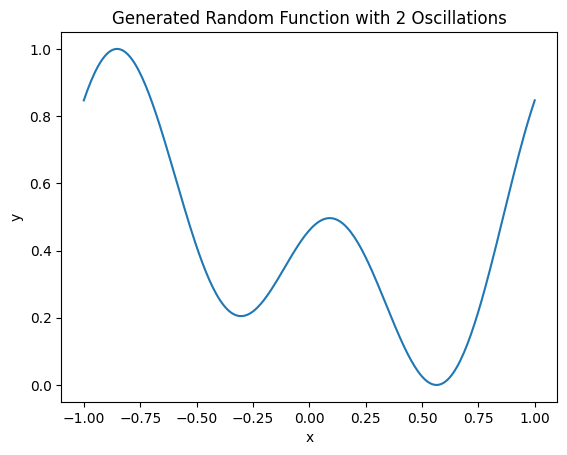

In [132]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_random_function():
    # Generate x values
    x = torch.linspace(-1, 1, 256)

    # Generate random coefficients for sine and cosine functions with reduced variation
    coefficients = torch.randn(2) * 0.1  # Only 2 coefficients for 2 oscillations
    coefficients = coefficients.sort().values  # Sort the coefficients

    # Create a random function using the coefficients
    random_function = torch.zeros_like(x)
    for i, coeff in enumerate(coefficients):
        random_function += coeff * torch.sin((i + 1) * np.pi * x) + coeff * torch.cos((i + 1) * np.pi * x)

    # Normalize the random function
    random_function = (random_function - random_function.min()) / (random_function.max() - random_function.min())

    return x, random_function

# Plot the random function
x, random_function = plot_random_function()
plt.plot(x.numpy(), random_function.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Random Function with 2 Oscillations')
plt.show()

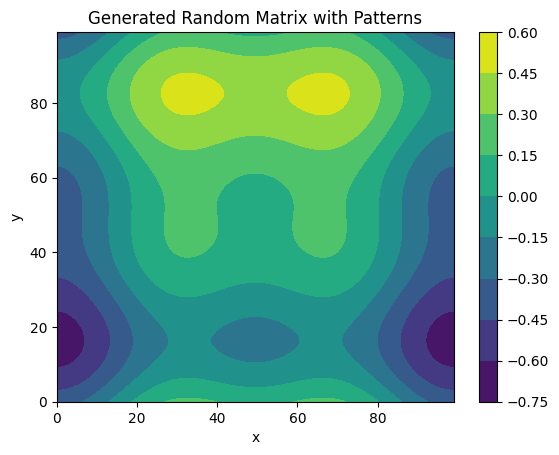

In [134]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def plot_random_matrix():
    # Generate x and y values
    x = torch.linspace(-1, 1, 100)
    y = torch.linspace(-1, 1, 100)
    x, y = torch.meshgrid(x, y)

    # Generate random coefficients for sine and cosine functions
    coefficients = torch.randn(2) * 0.1  # Scale down the coefficients

    # Create a random matrix using the coefficients
    random_matrix = torch.zeros_like(x)
    for i, coeff in enumerate(coefficients):
        random_matrix += coeff * torch.sin((i + 1) * np.pi * x) + coeff * torch.cos((i + 1) * np.pi * y)
    return random_matrix

random_matrix = plot_random_matrix()
# Plot the random matrix
plt.contourf(random_matrix.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Random Matrix with Patterns')
plt.colorbar()
plt.show()